
<a href="https://colab.research.google.com/github/kokchun/Machine-learning-AI22/blob/main/Exercises/E00_linear_regression.ipynb" target="_parent"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp; to see hints and answers.

---
# Linear regression exercises

---
These are introductory exercises in Machine learning with focus in **linear regression** .

<p class = "alert alert-info" role="alert"><b>Note</b> all datasets used in this exercise can be found under Data folder of the course Github repo</p>

<p class = "alert alert-info" role="alert"><b>Note</b> that in cases when you start to repeat code, try not to. Create functions to reuse code instead. </p>

<p class = "alert alert-info" role="alert"><b>Remember</b> to use <b>descriptive variable, function, index </b> and <b> column names</b> in order to get readable code </p>

The number of stars (\*), (\*\*), (\*\*\*) denotes the difficulty level of the task

---

## 0. Simulate phone dataset (*)

We want to simulate data $(x,y)$ to represent cost for phone subscriptions, with: 

- $x$ - called minutes per month
- $y$ - SEK per month 

&nbsp; a) Use ```numpy.random.normal()``` to simulate a dataset with the following requirements:(*)
- set a seed to 42 (for reproducibility and reference)
- simulate 400 x-values from the r.v. $X \sim \mathcal{N}(100, 100)$ 
- take absolute value of these x-values
- simulate noise 400 noise values from r.v. $\epsilon \sim \mathcal{N(0, 50)}$ 
- Let $y = 2x+25+\epsilon$
- plot the data set 

&nbsp; b) Now we want to remove some outliers according to this assumption: (*)
- no one talks more than 300 min using this type of subscription
- no ones costs can be negative
- plot the new dataset
- also plot ground truth using the true parameters $\beta_0 = 25, \beta_1 = 2$

&nbsp; c) Insert the values into a DataFrame (*)

<details>

<summary>Answer</summary>

<img src="../assets/simulated_phone_dataset_0.png" height="200"/>

a) 

Number of points x ≥ 300 min: 8

Number of points y < 0 kr: 6


b)

Length of x, outliers removed 386

Length of y, outliers removed 386

c)

df.head()

|    |   Minutes |     Cost |
|---:|----------:|---------:|
|  0 |   59.4428 | 168.721  |
|  1 |   40.0625 |  98.2118 |
|  2 |  100.524  | 258.433  |
|  3 |  104.698  | 310.548  |
|  4 |   54.9935 | 123.279  |


</details>

---

Antal punkter över 300: 11st
Antal punkter under 0: 8st


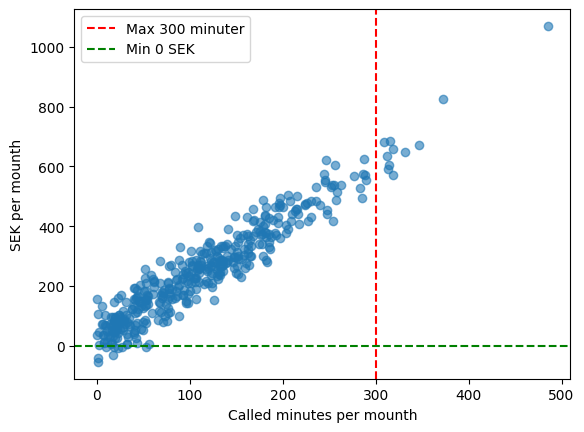

In [1]:
#a)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

np.random.seed(42)
x = np.abs(np.random.normal(100, 100, 400))
E = np.random.normal(0, 50, 400) # Brus
y = 2 * x + 25 + E

print(f"Antal punkter över 300: {(x >= 300).sum()}st")
print(f"Antal punkter under 0: {np.sum(y <= 0)}st")

matrix = np.column_stack((x, y))

plt.axvline(x=300, color="red", linestyle="--", label="Max 300 minuter")
plt.axhline(y=0, color="green", linestyle="--", label="Min 0 SEK")

plt.scatter(x, y, alpha=0.6)
plt.xlabel("Called minutes per mounth")
plt.ylabel("SEK per mounth")

plt.legend()
plt.show()

Förklaring:

1: np.random.seed(42): Säkerställer att samma slumpmässiga värden genereras varje gång koden körs.

2: np.random.normal(100, 100, 400): Skapar 400 x-värden från en normalfördelning med medelvärde 100 och standardavvikelse 10.

3: np.abs(): Tar absolutvärdet av x-värdena för att undvika negativa minuter.

4: np.random.normal(0, 50, 400): Skapar 400 brusvärden från en normalfördelning med medelvärde 0 och standardavvikelse 50.

5: y = 2 * x + 25 + epsilon: Beräknar y-värdena med hjälp av den givna formeln.

6: plt.scatter(): Plottar datapunkterna för att visualisera datasetet.

Storlek på X efter filtrering: 381
Storlek på y efter filtrering: 381


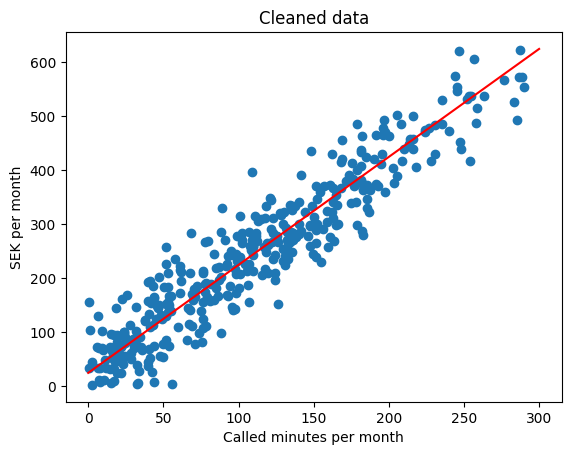

In [2]:
#b)
filter = (x <= 300) & (y >= 0)
# filter.shape

X = x[filter]
y = y[filter]

print(f"Storlek på X efter filtrering: {len(X)}")
print(f"Storlek på y efter filtrering: {len(y)}")


plt.scatter(X, y)
plt.ylabel("SEK per month")
plt.xlabel("Called minutes per month")
plt.title("Cleaned data")

xGroundTruth = np.linspace(0, 300, 100)
yGroundTruth = 25 + 2 * xGroundTruth

plt.plot(xGroundTruth, yGroundTruth, color='red')
plt.show()

In [3]:
#c)
df = pd.DataFrame({"Minutes": X, "Cost": y})
df.head()

,Minutes,Cost
0,149.671415,244.621448
1,86.173570,167.378389
2,164.768854,354.799893
3,252.302986,531.955001
4,76.584663,155.666051


## 1. Train|test split (*)

Before moving on with linear regression we shall first perform a train-test-split. 

&nbsp; a) Create a train-test-split function with the following call signature: (*)

```py
def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction=.7: float, random_state=42: int, replace=False: bool) -> tuple
```

that returns the tuple:
```
(X_train, X_test, y_train, y_test)
```

&nbsp; b) Now use this to split up your data into a training set and test set. Check manually that the split is performed correctly. (*)


<details>

<summary>Hint</summary>

b) Check the length of each set, and check the indices of the sorted sets that they don't overlap and are not missing. Also check that they sum up to what you expect.

</details>

<br/>

<details>

<summary>Answer</summary>

Using default 0.7: 
- length of X_train: 270
- length of X_test: 116
- length of y_train: 270
- length of X_test: 116

</details>

---

In [4]:
X = pd.DataFrame(X)
y = pd.DataFrame(y)

def train_test_split(x_clean: pd.DataFrame, y_clean: pd.DataFrame, train_fraction: float=.7, random_state: int= 42, replace: bool= False) -> tuple:
    np.random.seed(random_state)

    """Beräknar antalet prover (rader) i x_clean. Här används shape[0] för att hämta antal 
    rader (exempelvis om x_clean har 100 rader, kommer num_samples vara 100) """
    num_samples = x_clean.shape[0]

    """Beräknar antalet prover som ska användas för träning. Om train_fraction = 0.7 och num_samples = 100, 
    så kommer num_train = 70. Detta innebär att 70 prover ska användas för träning. """
    num_train = int(num_samples * train_fraction)

    """np.arange(num_samples): Skapar en array med alla index från 0 till num_samples-1.
    np.random.choice(...): Väljer num_samples antal index från arrayen med möjlighet till upprepning om replace=True. 
    Om replace=False, kommer varje index bara väljas en gång (utan ersättning)."""
    indices = np.random.choice(np.arange(num_samples), size= num_samples, replace=replace)

    train_indices = indices[:num_train]
    test_indices = indices[num_train:]

    X_train = x_clean.iloc[train_indices]
    X_test = x_clean.iloc[test_indices]

    y_train = y_clean.iloc[train_indices]
    y_test = y_clean.iloc[test_indices]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"Lenght of X_train: {len(X_train)}")
print(f"Lenght of X_test: {len(X_test)}")
print(f"Lenght of y_train: {len(y_train)}")
print(f"Lenght of y_test: {len(y_test)}")

Lenght of X_train: 266
Lenght of X_test: 115
Lenght of y_train: 266
Lenght of y_test: 115


## 2. Simple linear regression with normal equation (*)

Use the normal equation for simple linear regression to solve for the coefficients $\hat{\beta} = (\beta_0, \beta_1)$. Note that you should only use the training data to fit the regression line, and not data from the test set. Plot the the regression line, together with ground truth and training data. 

<details>

<summary>Hint</summary>

It is important to keep track of the shapes of the vectors, matrices in order for matrix multiplication matmul "@" to work correctly. Also, if you have series object, you need to convert it to numpy. 

</details>

<br/>

<details>

<summary>Answer</summary>


<img src="../assets/Reg_line_normal_eq.png" height="200"/>

</details>

---

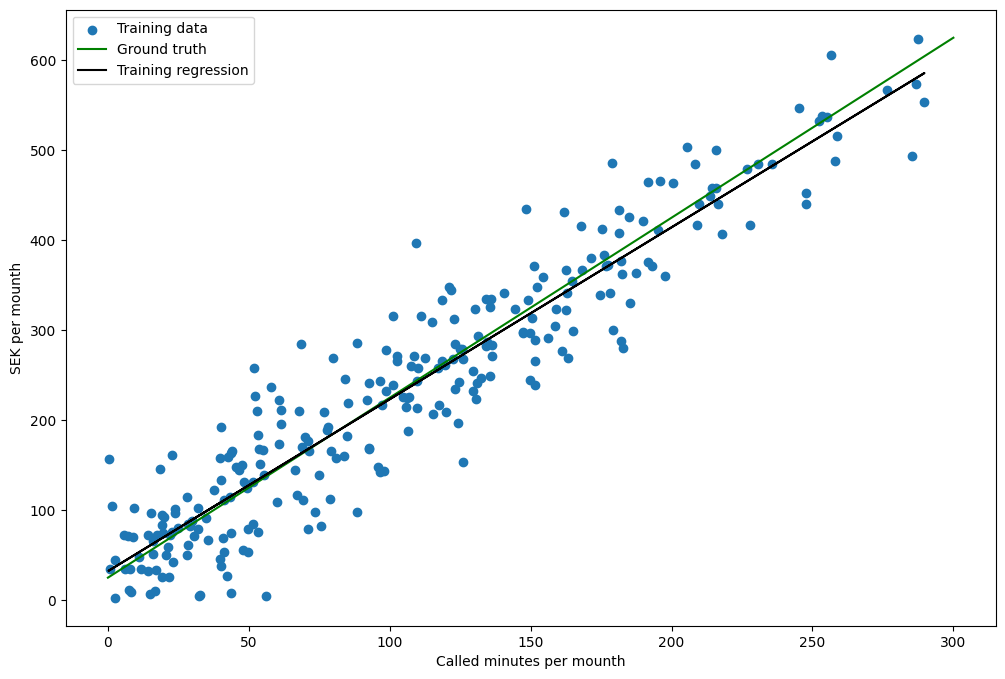

In [5]:
X_train = X_train.values.flatten()
y_train = y_train.values.flatten()

OLS = lambda X, y: np.linalg.pinv(X.T @ X) @ X.T @ y
add_bias = lambda X: np.column_stack([np.ones(X.shape[0]), X])
X_train = add_bias(X_train)
B = OLS(X_train, y_train)

plt.figure(figsize=(12, 8))
plt.scatter(X_train[:,1], y_train, label="Training data")

plt.plot(xGroundTruth, yGroundTruth, color='green', label="Ground truth")
# plt.plot(X_test, X_test@B, color='red', label="Regression line")
plt.plot(X_train[:,1], X_train@B, color='black', label="Training regression")


plt.xlabel("Called minutes per mounth")
plt.ylabel("SEK per mounth")
plt.legend()
plt.show()

## 3. Prediction and evaluation (*)

&nbsp; a) Use your model to make prediction on testing data. Plot the prediction cost against X_test, and y_test against X_test. (*)

&nbsp; b) Calculate MAE, MSE, RMSE (*)

<details>

<summary>Hint</summary>

Calculate y_pred from X_test and use y_test and y_pred to compute different evaluation metrics.

Careful with dimensions when computing the evaluation metrics, else it can be catastrophical logical errors due to numpy broadcasting feature.

Note that after you have calculate the error metrics on test data you are not allowed to change any parameters to make the line fit better to the testing data.

</details>

<br/>

<details>

<summary>Answer</summary>

a) 

<img src="../assets/eval_simple_lin_reg.png" height="200"/>

b)

Mean absolute error on testing data: 36.97 kr

Mean squared error on testing data: 2374 kr^2

Root mean squared error on testing data: 48.72 kr

</details>

---

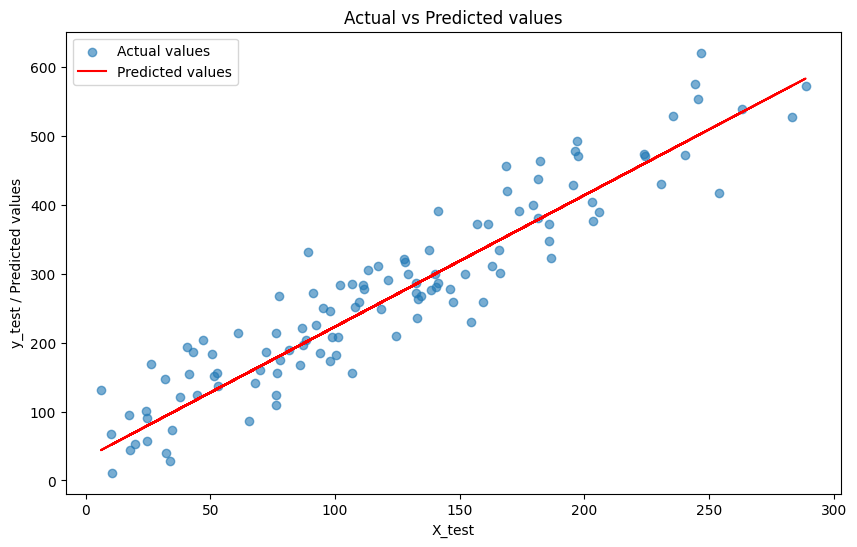

MAE: 40.12
MSE: 2401.58
RMSE: 49.01


In [6]:
# from sklearn.linear_model import LinearRegression

# model = LinearRegression()
# model.fit(X_train, y_train)

y_pred = lambda X, B: X @ B
X_test = add_bias(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X_test[:,1], y_test, label='Actual values', alpha=0.6)
plt.plot(X_test[:,1], y_pred(X_test, B), color='red', label='Predicted values')
plt.xlabel('X_test')
plt.ylabel('y_test / Predicted values')
plt.title('Actual vs Predicted values')
plt.legend()
plt.show()

y_test = np.array(y_test).reshape(-1)  # Make sure it's a 1D array
# y_pred = y_pred(X_test, B).reshape(-1)  # Make sure it's a 1D array

n = len(y_test)
# y_test = y_test.values 
y_pred = np.reshape(y_pred(X_test, B), (n))

MAE = np.divide(1, n) * np.sum(np.abs(y_test - y_pred))
MSE = np.divide(1, n) * np.sum(np.square(y_test - y_pred))
RMSE = np.sqrt(MSE)

print(f"MAE: {MAE:.2f}")
print(f"MSE: {MSE:.2f}")
print(f"RMSE: {RMSE:.2f}")

Del a)

Prediktioner
Skapar design matrix för testdata Vi skapar en design matrix X_test_matrix med en kolumn av ettor för intercept och en kolumn med minutvärden från testdata. Gör prediktioner med beta-koefficienter Vi använder våra beräknade beta-koefficienter (beta) för att göra prediktioner på testdata. Plottar faktiska värden och prediktioner Vi plottar både faktiska testvärden (y_test) och prediktioner (y_pred) för att visualisera modellens prestanda.

Del b)

Utvärderingsmått
MAE (Mean Absolute Error) Genomsnittligt absolut fel Beräknar det genomsnittliga absoluta felet mellan faktiska värden och prediktioner. Mindre känslig för outliers MAE är mindre känslig för extrema värden jämfört med MSE.

MSE (Mean Squared Error)
Genomsnittligt kvadratfel Beräknar det genomsnittliga kvadratiska felet. Straffar stora fel hårdare MSE straffar stora fel mer än MAE.

RMSE (Root Mean Squared Error)
Roten ur MSE Beräknar roten ur MSE. Fel i samma enhet som data RMSE ger ett fel i samma enhet som originaldata, vilket gör det lättare att tolka.

## 4. Simulate more explanatory variables (\*)

Now we will simulate the explanatory variables for minutes, text messages and amount of surf. For reference and reproducibility use numpy random seed 42. Assume there is:

- mean start cost: 25kr
- mean cost per minute: 2kr
- mean cost per sms: 50 öre
- mean cost per GB: 50kr

Then the model for the cost will be:
$y = 25 + 2x_1 + 0.5x_2 + 50x_3 + \epsilon$, where

- $x_i$ sampled from r.v. $X_i$ for $i = \{1,2,3\}$
- $X_1 \sim |\mathcal{N}(100,100)|$, (absolute value)
- $X_2 \sim \mathcal{U}(0,50)$, (discrete uniform distribution)
- $X_3 \sim |\mathcal{N}(0,2)|$,
- $\epsilon \sim \mathcal{N}(0,50)$

&nbsp; a) Simulate 10000 samples of each of $x_1, x_2, x_3$ and $y$ and save them in a DataFrame. Also add an intercept column containing ones. (\*)

&nbsp; b) Make histograms for each of the explanatory variables $x_1, x_2, x_3$ and the response variable $y$ (\*)

&nbsp; c) Clean the data using the following constraints (\*)

- surf should be less than 4
- minutes should be less than 300
- cost should be larger than 0

&nbsp; d) Make new histograms for the variables. (\*)

<details>

<summary>Hint</summary>
Your data analysis skill toolbox together with statistics and linear algebra skills are getting quite handy here.

</details>

<br/>

<details>

<summary>Answer</summary>

a)

|      | Intercept | Minutes | SMS | Surf (GB) |    Cost |
| ---: | --------: | ------: | --: | --------: | ------: |
|    0 |         1 | 149.671 |  41 |   2.26301 | 502.396 |
|    1 |         1 | 86.1736 |  16 | 0.0315695 | 179.072 |
|  ... |       ... |     ... | ... |       ... |     ... |
| 9318 |         1 | 149.577 |  31 |   3.43929 | 536.176 |
| 9319 |         1 | 164.439 |  43 |   1.40641 | 406.674 |

b)

<img src="../assets/hist_variables.png" height="200"/>

d)

<img src="../assets/hist_var_cleaned.png" height="200"/>

</details>

---


In [7]:
np.random.seed(42)
x1 = np.abs(np.random.normal(100, 100, 10000))
x2 = np.random.randint(0, 50, 10000)
x3 = np.abs(np.random.normal(0, 2, 10000))
E = np.random.normal(0, 50, 10000) # Brus

y = 25 + 2*x1 + .5*x2 + 50*x3 + E

# print(x3.size) 

df = pd.DataFrame({"Minutes":x1, "SMS":x2, "Surf":x3, "Cost":y})
df.insert(0, "Intercept", 1)

df.describe()


,Intercept,Minutes,SMS,Surf,Cost
count,10000.0,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.0,116.650879,24.581100,1.585903,349.509038
std,0.0,80.118044,14.508235,1.195842,179.457329
min,1.0,0.033132,0.000000,0.000144,-96.470950
25%,1.0,51.628456,12.000000,0.621678,215.368494
50%,1.0,104.746533,24.000000,1.353720,329.546608
75%,1.0,168.338908,37.000000,2.297684,466.845680
max,1.0,492.623771,49.000000,8.958169,1164.547248


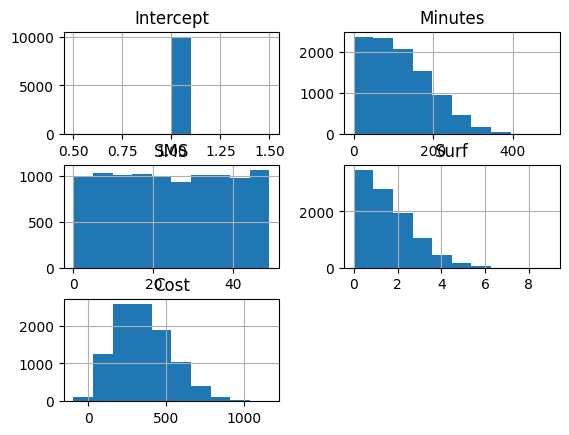

In [8]:
df.hist();

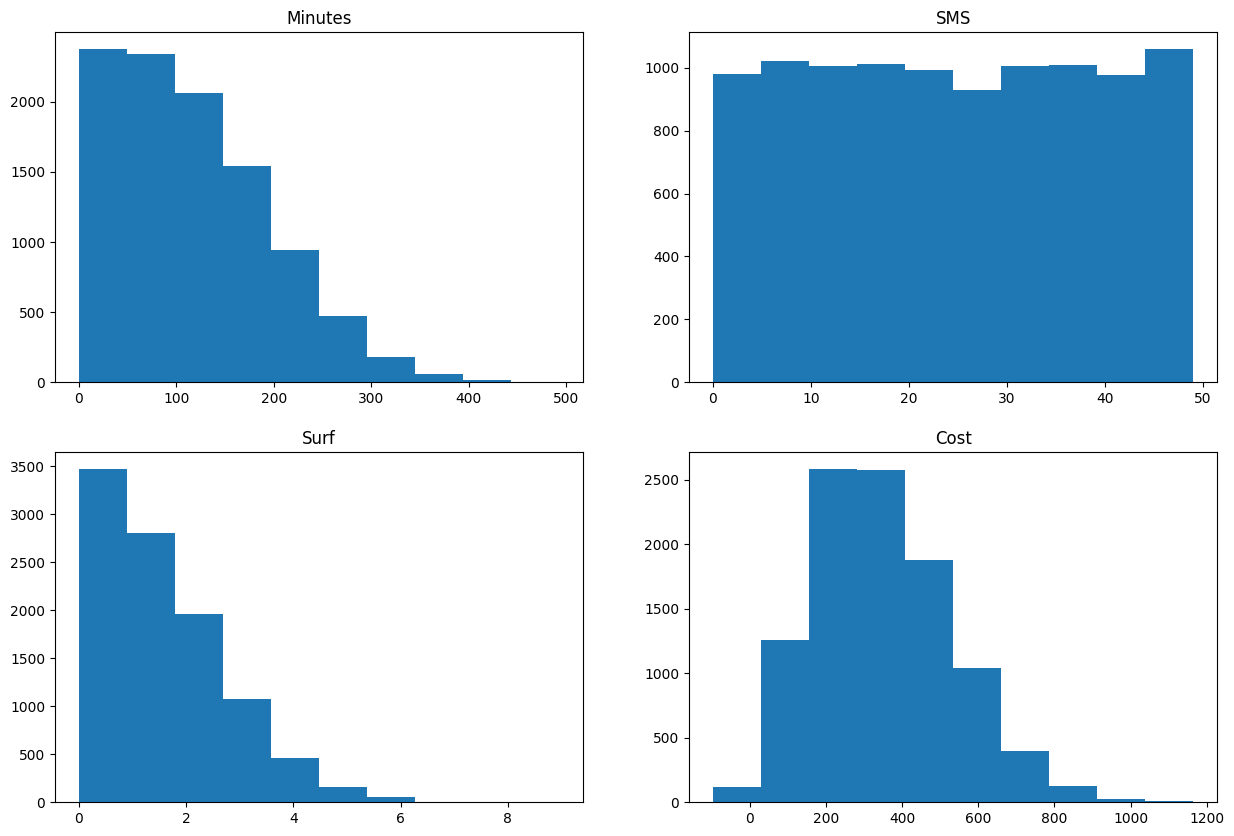

In [9]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(df["Minutes"])
plt.title("Minutes")

plt.subplot(2, 2, 2)
plt.hist(df["SMS"])
plt.title("SMS")

plt.subplot(2, 2, 3)
plt.hist(df["Surf"])
plt.title("Surf")

plt.subplot(2, 2, 4)
plt.hist(df["Cost"])
plt.title("Cost")

plt.show()



In [10]:
#- surf should be less than 4
# - minutes should be less than 300
# - cost should be larger than 0

df = df[(df["Surf"] < 4) & (df["Minutes"] < 300) & (df["Cost"] > 0)]
df.head()

,Intercept,Minutes,SMS,Surf,Cost
0,1,149.671415,41,2.263011,502.396003
1,1,86.173570,16,0.031570,179.072107
2,1,164.768854,30,0.808925,430.008213
3,1,252.302986,33,2.625826,647.244277
4,1,76.584663,37,3.388079,398.016588


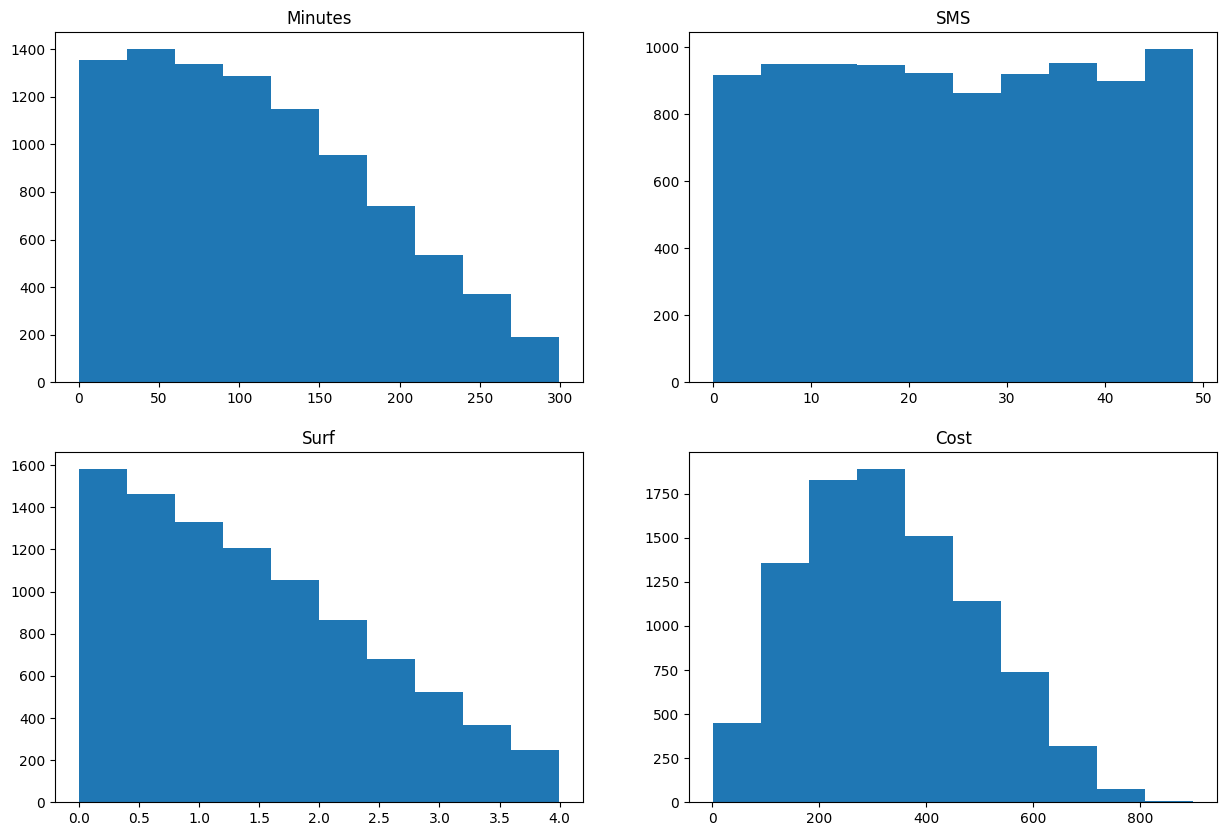

In [11]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.hist(df["Minutes"])
plt.title("Minutes")

plt.subplot(2, 2, 2)
plt.hist(df["SMS"])
plt.title("SMS")

plt.subplot(2, 2, 3)
plt.hist(df["Surf"])
plt.title("Surf")

plt.subplot(2, 2, 4)
plt.hist(df["Cost"])
plt.title("Cost")

plt.show()



## 5. Multiple linear regression (*)

&nbsp; a) Perform a train|test split with 0.8 of the data for training. (*)

&nbsp; b) Use the normal equation to compute $\hat{\beta}$ (*)

&nbsp; c) Predict on the test data and compute MAE, MSE and RMSE. (*)

&nbsp; d) Now repeat 4a), 4c), 5a), 5b) using 10, 100, 1000, 10000, 100000, 1000000 samples, and calculate RMSE for each of these simulations. Plot the RMSE against sample size. (**)


<details>

<summary>Hint</summary>

It is important to keep track of the shapes of the vectors, matrices in order for matrix multiplication matmul "@" to work correctly. Also, if you have series object, you need to convert it to numpy. 

</details>

<br/>

<details>
<summary>Answer</summary>


<img src="../assets/RMSE_simulation.png" height="200"/>

</details>

In [12]:
X, y = df.drop("Cost", axis=1), df["Cost"]

In [13]:
def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction: float=.8, random_state: int= 42, replace: bool= False) -> tuple:
    np.random.seed(random_state)

    """Beräknar antalet prover (rader) i x_clean. Här används shape[0] för att hämta antal 
    rader (exempelvis om x_clean har 100 rader, kommer num_samples vara 100) """
    num_samples = X.shape[0]

    """Beräknar antalet prover som ska användas för träning. Om train_fraction = 0.7 och num_samples = 100, 
    så kommer num_train = 70. Detta innebär att 70 prover ska användas för träning. """
    num_train = int(num_samples * train_fraction)

    """np.arange(num_samples): Skapar en array med alla index från 0 till num_samples-1.
    np.random.choice(...): Väljer num_samples antal index från arrayen med möjlighet till upprepning om replace=True. 
    Om replace=False, kommer varje index bara väljas en gång (utan ersättning)."""
    indices = np.random.choice(np.arange(num_samples), size= num_samples, replace=replace)

    train_indices = indices[:num_train]
    test_indices = indices[num_train:]

    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]

    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f"Lenght of X_train: {len(X_train)}")
print(f"Lenght of X_test: {len(X_test)}")
print(f"Lenght of y_train: {len(y_train)}")
print(f"Lenght of y_test: {len(y_test)}")

Lenght of X_train: 7456
Lenght of X_test: 1864
Lenght of y_train: 7456
Lenght of y_test: 1864


In [14]:
# X_train = X_train.values.flatten()
# y_train = y_train.values.flatten()

OLS = lambda X, y: np.linalg.pinv(X.T @ X) @ X.T @ y
add_bias = lambda X: np.column_stack([np.ones(X.shape[0]), X])
X_train = add_bias(X_train)
B = OLS(X_train, y_train)

In [15]:
y_pred = lambda X, B: X @ B
X_test = add_bias(X_test)
y_test = np.array(y_test).reshape(-1)  # Make sure it's a 1D array
# y_pred = y_pred(X_test, B).reshape(-1)  # Make sure it's a 1D array

n = len(y_test)
# y_test = y_test.values 
y_pred = np.reshape(y_pred(X_test, B), (n))

MAE = np.divide(1, n) * np.sum(np.abs(y_test - y_pred))
MSE = np.divide(1, n) * np.sum(np.square(y_test - y_pred))
RMSE = np.sqrt(MSE)

print(f"MAE: {MAE:.2f}")
print(f"MSE: {MSE:.2f}")
print(f"RMSE: {RMSE:.2f}")

print(len(y_pred))

MAE: 39.24
MSE: 2421.26
RMSE: 49.21
1864


[292.83858194537777, 45.285277036149246, 49.24102405422408, 49.206315412923814, 49.6953567613077, 49.779278675090765]


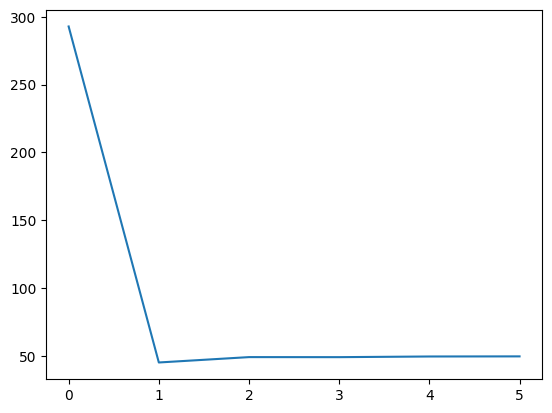

In [16]:
loop = (10, 100, 1000, 10000, 1000000, 10000000)
rmse = []
for i in loop:
    np.random.seed(42)
    x1 = np.abs(np.random.normal(100, 100, i))
    x2 = np.random.randint(0, 50, i)
    x3 = np.abs(np.random.normal(0, 2, i))
    E = np.random.normal(0, 50, i) # Brus

    y = 25 + 2*x1 + .5*x2 + 50*x3 + E

    df = pd.DataFrame({"Minutes":x1, "SMS":x2, "Surf":x3, "Cost":y})
    df.insert(0, "Intercept", 1)
    df = df[(df["Surf"] < 4) & (df["Minutes"] < 300) & (df["Cost"] > 0)]
    X, y = df.drop("Cost", axis=1), df["Cost"]

    X_train, X_test, y_train, y_test = train_test_split(X, y)

    OLS = lambda X, y: np.linalg.pinv(X.T @ X) @ X.T @ y
    add_bias = lambda X: np.column_stack([np.ones(X.shape[0]), X])
    X_train = add_bias(X_train)
    B = OLS(X_train, y_train)

    y_pred = lambda X, B: X @ B
    X_test = add_bias(X_test)
    y_test = np.array(y_test).reshape(-1)  # Make sure it's a 1D array
    # y_pred = y_pred(X_test, B).reshape(-1)  # Make sure it's a 1D array

    n = len(y_test)
    # y_test = y_test.values 
    y_pred = np.reshape(y_pred(X_test, B), (n))

    MAE = np.divide(1, n) * np.sum(np.abs(y_test - y_pred))
    MSE = np.divide(1, n) * np.sum(np.square(y_test - y_pred))
    RMSE = np.sqrt(MSE)
    rmse.append(RMSE)

# print(f"RMSE: {RMSE:.2f}")
print(rmse)

plt.plot(rmse)
plt.show()

def train_test_split(X: pd.DataFrame, y: pd.DataFrame, train_fraction: float=.8, random_state: int= 42, replace: bool= False) -> tuple:
    np.random.seed(random_state)

    """Beräknar antalet prover (rader) i x_clean. Här används shape[0] för att hämta antal 
    rader (exempelvis om x_clean har 100 rader, kommer num_samples vara 100) """
    num_samples = X.shape[0]

    """Beräknar antalet prover som ska användas för träning. Om train_fraction = 0.7 och num_samples = 100, 
    så kommer num_train = 70. Detta innebär att 70 prover ska användas för träning. """
    num_train = int(num_samples * train_fraction)

    """np.arange(num_samples): Skapar en array med alla index från 0 till num_samples-1.
    np.random.choice(...): Väljer num_samples antal index från arrayen med möjlighet till upprepning om replace=True. 
    Om replace=False, kommer varje index bara väljas en gång (utan ersättning)."""
    indices = np.random.choice(np.arange(num_samples), size= num_samples, replace=replace)

    train_indices = indices[:num_train]
    test_indices = indices[num_train:]

    X_train = X.iloc[train_indices]
    X_test = X.iloc[test_indices]

    y_train = y.iloc[train_indices]
    y_test = y.iloc[test_indices]

    return X_train, X_test, y_train, y_test




---

Kokchun Giang

[LinkedIn][linkedIn_kokchun]

[GitHub portfolio][github_portfolio]

[linkedIn_kokchun]: https://www.linkedin.com/in/kokchungiang/
[github_portfolio]: https://github.com/kokchun/Portfolio-Kokchun-Giang

---